In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import glob, os
import torch

In [2]:
path = '/pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/lkhd_gaussian_std_0.1_scaled_True_steps_50_20240202-2122'
pt_flist = glob.glob(os.path.join(path, '*.pt'))

In [3]:
pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])

In [4]:
fnal_mse = []

for _i, _idx in enumerate(pt_indices):
    _pt = torch.load(os.path.join(path, f'{_idx}.pt'))
    # print(_pt.keys())
    # mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
    mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2)
    _fnal_mse = (mean_preds - _pt['true_params'][None]).norm(dim=-1)[-25]
    fnal_mse.append(_fnal_mse.item())
    # if _i >2:
    #     break

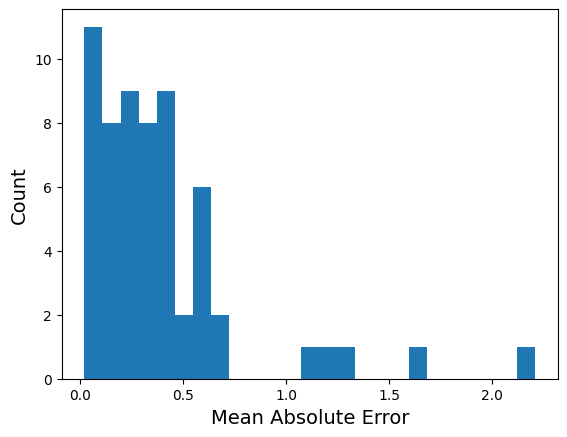

In [5]:
fig, ax = plt.subplots(1,1)
ax.hist(fnal_mse, bins=25);
ax.set_xlabel('Mean Absolute Error', fontdict={'size': 14})
ax.set_ylabel('Count', fontdict={'size': 14});

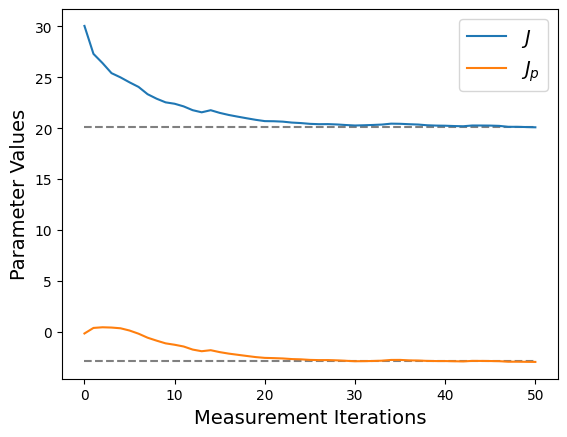

In [6]:
fig, ax = plt.subplots(1,1)
ax.plot(mean_preds[:,0], label='$J$')
ax.plot(mean_preds[:,1], label='$J_{p}$')
ax.hlines(_pt['true_params'], 0, 50, color='gray', linestyles='dashed')
ax.legend(fontsize=14)

ax.set_xlabel('Measurement Iterations', fontdict={'size': 14})
ax.set_ylabel('Parameter Values', fontdict={'size': 14});

In [7]:
from sklearn.neighbors import KernelDensity
import numpy as np

In [8]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(_pt['positions'][-1], sample_weight=_pt['weights'][-1])

In [9]:
J, Jp = np.meshgrid(np.linspace(20, 40, 401), np.linspace(-5, 5, 201))
param_grid = np.concatenate([J[..., None], Jp[..., None]], axis=-1)

In [10]:
log_density = kde.score_samples(param_grid.reshape(-1, 2)).reshape(J.shape)

/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


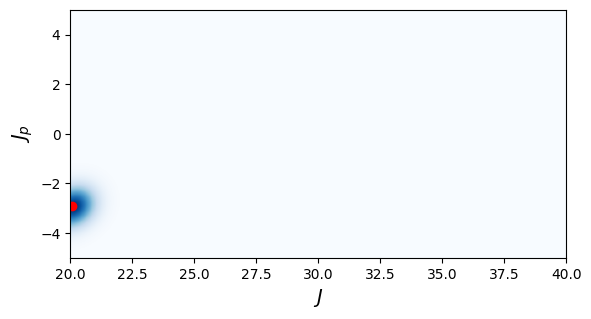

In [11]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_density), origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap='Blues')
ax.scatter(_pt['true_params'][0], _pt['true_params'][1], color='red')
ax.set_xlabel('$J$', fontdict={'size': 14})
ax.set_ylabel('$J_{p}$', fontdict={'size': 14});